In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr

%reload_ext autoreload
%autoreload 2
from HelperFunctions import plot_corr, minibatch, subcategoryttest, subcategoryANOVA

In [2]:
df=pd.read_csv('lean_df_3.csv',index_col='id')

/home/auscheng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (35,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/auscheng/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


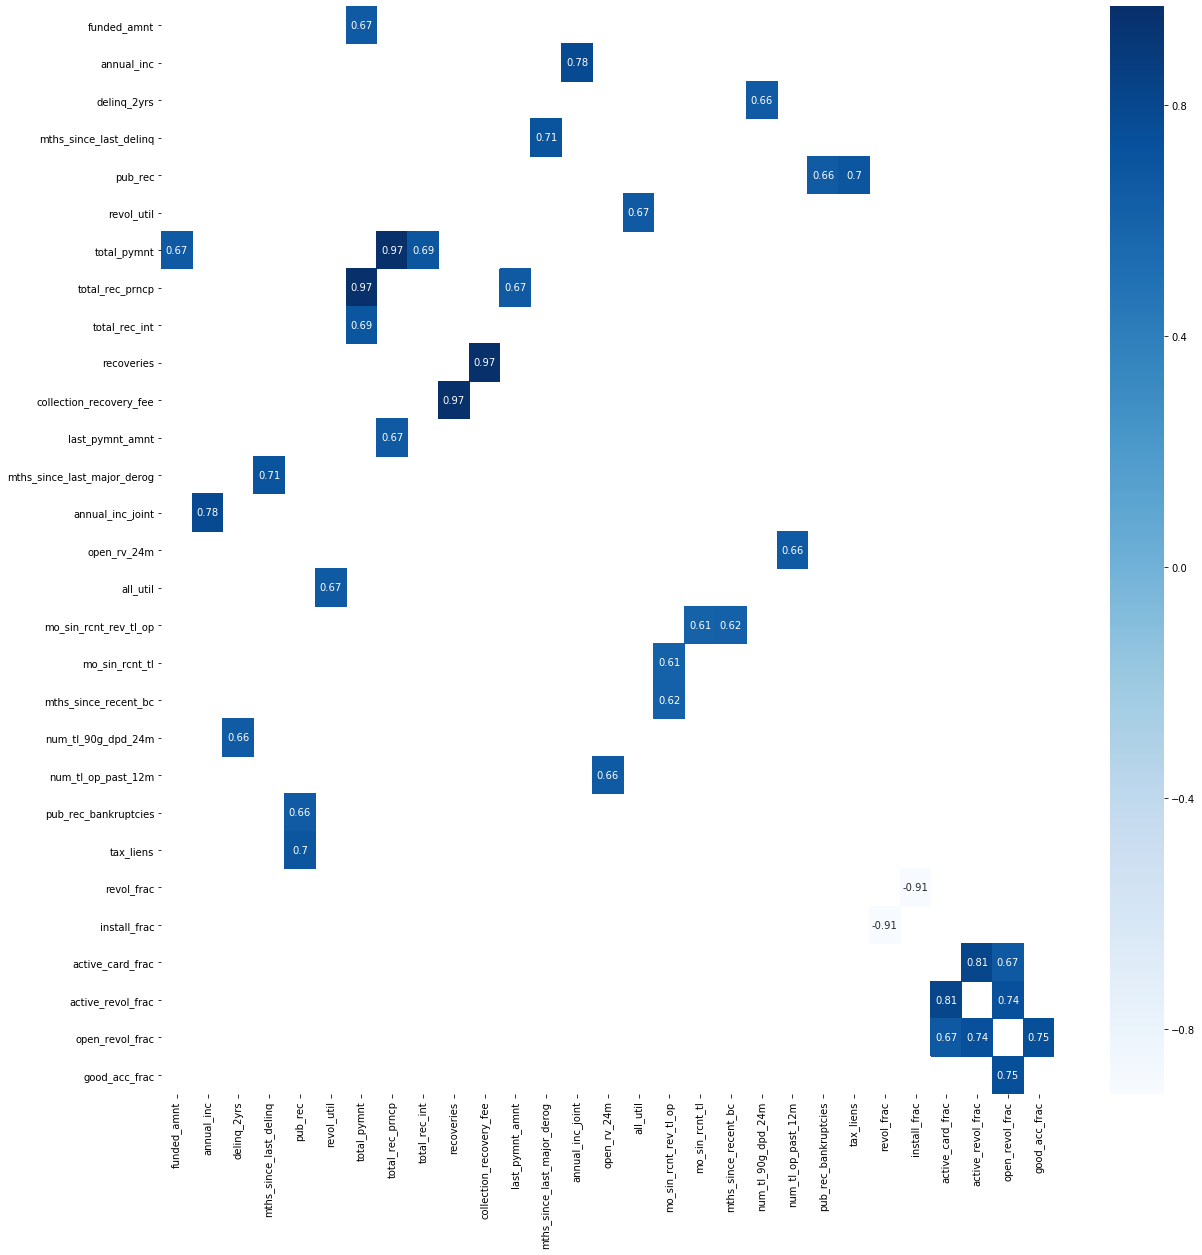

In [3]:
plot_corr(df,threshold=0.6,size=20)

#### We don't care about the type of accounts opened but the actual utilization of the type of accounts.
#### drop the revolving and installment accounts opened in past months info.

In [4]:
df.drop(['open_rv_24m','open_il_12m'],axis=1,inplace=True)
# list(df.columns)

In [5]:
# Keep: df.loc[:,['tot_hi_cred_lim','total_il_high_credit_limit','total_rev_hi_lim']]

In [6]:
df_number = df.select_dtypes(include = 'number')
df_object = df.select_dtypes(include = 'object')
df_category = df.select_dtypes(include = 'category')
df_boolean = df.select_dtypes(include = 'bool')
df_datetime = df.select_dtypes(include = 'datetime')
df_timedelta = df.select_dtypes(include = 'timedelta')
#######################################################
nominal_var=list(df_object.columns)
ordinal_var=list(df_number.columns)
continuous_var=list(df_number.columns)
time_var=list(df_datetime.columns)

#### Dropping features not known during issuance date. Will need to keep a couple to create the target variable

In [7]:
#### Features not known during issuance date or is current: 
# out_prncp_inv             <---- drop
# total_pymnt               <--- KEEP to create target variable (profit for total yield)
# total_pymnt_inv           <---- drop
# total_rec_prncp           <---- drop
# total_rec_int             <---- drop
# total_rec_late_fee        <---- drop
# recoveries                <---- drop
# collection_recovery_fee   <---- KEEP to create target variable (profit for total yield)
# last_pymnt_d              <---- KEEP to create loan duration 
# last_pymnt_amnt           <---- drop
# next_pymnt_d              <---- drop
# last_credit_pull_d        <---- drop

In [8]:
df.drop(['total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','last_pymnt_amnt','next_pymnt_d','last_credit_pull_d'],axis=1,inplace=True)

#### dropping oldest account opened because covered by earlieset credit line

In [9]:
df.drop(['mo_sin_old_il_acct','mo_sin_old_rev_tl_op'],axis=1,inplace=True)

# Human intuition feature elimination
#### 'emp_title' has too many subcategories. it is also self reporting. purpose more important
#### inq_last_6_mnths is covered by inq_last_12m
#### out_prncp is not known before issuance and is not relevant for target variable calculation
#### mths_since_rcnt_il is covered by mo_sin_rcnt_tl (months since latest account)
#### max_bal_bc is covered by total outstanding balance
#### inq_fi the personal finance factor is too mysterious. we are not sure of its effect and it has relatively few observations, so drop
#### total_cu_tl is dropped for same reason as above and should be covered by 
#### mo_sin_rcnt_rev_tl_op covered by mo_sin_rcnt_tl (months since latest account)
#### mths_since_recent_bc covered by mo_sin_rcnt_tl (months since latest account)
#### mths_since_recent_inq covered by inq_last_12m
#### num_bc_sats covered by num_sats --> good_accounts
#### num_tl_120dpd_2m has a time window that is too short and is covered by num_tl_90g_dpd_24m

In [10]:
df.drop(['emp_title','inq_last_6mths','out_prncp','mths_since_rcnt_il',\
         'max_bal_bc','inq_fi','total_cu_tl','mo_sin_rcnt_rev_tl_op',\
         'mths_since_recent_bc','mths_since_recent_inq','num_bc_sats','num_tl_120dpd_2m',\
         'fully_invested'],axis=1,inplace=True)

In [11]:
df.head()

,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_util,total_acc,initial_list_status,total_pymnt,collection_recovery_fee,last_pymnt_d,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,il_util,all_util,total_rev_hi_lim,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_rcnt_tl,num_accts_ever_120_pd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_il_high_credit_limit,fico,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68407277,3600.0,36 months,13.99,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,debt_consolidation,190xx,PA,5.91,0.0,Aug-2003,30.0,NaN,0.0,29.7,13.0,w,4421.723917,0.0,Jan-2019,0.0,30.0,Individual,NaN,NaN,NaN,0.0,722.0,36.0,34.0,9300.0,4.0,0.0,0.0,3.0,2.0,0.0,3.0,76.9,0.0,0.0,178050.0,13734.0,677.0,0.692308,0.230769,0.076923,0.555556,0.400000,0.444444,0.666667,0.444444,0.538462
68355089,24700.0,36 months,11.99,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,small_business,577xx,SD,16.06,1.0,Dec-1999,6.0,NaN,0.0,19.2,38.0,w,25679.660000,0.0,Jun-2016,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,73.0,29.0,111800.0,6.0,0.0,0.0,2.0,0.0,0.0,2.0,97.4,0.0,0.0,314017.0,24667.0,717.0,0.710526,0.157895,0.105263,0.629630,0.294118,0.185185,0.166667,0.740741,0.578947
68341763,20000.0,60 months,10.78,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,home_improvement,605xx,IL,10.78,0.0,Aug-2000,NaN,NaN,0.0,56.2,18.0,w,22705.924294,0.0,Jun-2017,0.0,NaN,Joint App,71000.0,13.85,Not Verified,0.0,0.0,73.0,65.0,14000.0,1.0,0.0,0.0,14.0,0.0,0.0,0.0,100.0,0.0,0.0,218418.0,14877.0,697.0,0.388889,0.333333,0.277778,0.571429,0.500000,0.428571,0.166667,0.571429,0.333333
66310712,35000.0,60 months,14.85,C,C5,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,debt_consolidation,076xx,NJ,17.06,0.0,Sep-2008,NaN,NaN,0.0,11.6,17.0,w,31464.010000,0.0,Feb-2019,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,70.0,45.0,67300.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,100.0,0.0,0.0,381215.0,18000.0,787.0,0.764706,0.117647,0.058824,0.769231,0.400000,0.384615,0.500000,0.769231,0.764706
68476807,10400.0,60 months,22.45,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,major_purchase,174xx,PA,25.37,1.0,Jun-1998,12.0,NaN,0.0,64.5,35.0,w,11740.500000,0.0,Jul-2016,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,84.0,78.0,34000.0,3.0,0.0,0.0,4.0,0.0,0.0,4.0,96.6,0.0,0.0,439570.0,88097.0,697.0,0.542857,0.285714,0.171429,0.473684,0.444444,0.315789,0.300000,0.368421,0.342857


In [12]:
df.shape

(2260668, 59)

In [13]:
# df.loc[:,['issue_d','loan_status','last_pymnt_d','next_pymnt_d']].iloc[0:50,:]

#### Making loan status a binary output variable 

In [14]:
df.loan_status.unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [15]:
df.loc[(df.loan_status=='Late (31-120 days)')|(df.loan_status=='Late (16-30 days)')|\
       (df.loan_status=='In Grace Period'),'loan_status']='Current'
df.loc[(df.loan_status=='Charged Off')|\
       (df.loan_status=='Does not meet the credit policy. Status:Charged Off'),'loan_status']='Default'
df.loc[(df.loan_status=='Does not meet the credit policy. Status:Fully Paid'),'loan_status']='Fully Paid'

In [16]:
df.loan_status.unique()

array(['Fully Paid', 'Current', 'Default'], dtype=object)

#### Turning time columns into proper datetime formats

In [17]:
df.issue_d=pd.to_datetime(df.issue_d)
df.earliest_cr_line=pd.to_datetime(df.earliest_cr_line)
df.last_pymnt_d=pd.to_datetime(df.last_pymnt_d)

In [18]:
pattern='([0-9][0-9]) months'
df['term']=df['term'].str.extract(pattern).values
df['term']=df['term'].astype('int')

In [19]:
df['term'].iloc[0]

36

In [20]:
# df.sort_values(by='issue_d')

# Creating new columns. Loan Duration and Profit
#### loan_duration=last_pyment_d-issue_d, profit=total_pymnt-collection_recovery_fee
#### Then dropping last_pyment_d, total_pymnt, collection_recovery_fee

In [21]:
df['loan_duration']=df['last_pymnt_d']-df['issue_d']
df['profit']=df['total_pymnt']-df['collection_recovery_fee']
df.drop(['last_pymnt_d','total_pymnt','collection_recovery_fee'],axis=1,inplace=True)

In [22]:
df.sample(10)

,funded_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,il_util,all_util,total_rev_hi_lim,inq_last_12m,chargeoff_within_12_mths,delinq_amnt,mo_sin_rcnt_tl,num_accts_ever_120_pd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_il_high_credit_limit,fico,revol_frac,install_frac,mort_frac,card_frac,active_card_frac,active_revol_frac,active_install_frac,open_revol_frac,good_acc_frac,loan_duration,profit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16532084,12000.0,60,16.29,D,D2,< 1 year,RENT,123000.0,Source Verified,2014-06-01,Fully Paid,debt_consolidation,113xx,NY,4.77,0.0,1976-11-01,49.0,NaN,0.0,13.8,54.0,f,0.0,50.0,Individual,NaN,NaN,NaN,0.0,4299.0,NaN,NaN,36500.0,NaN,0.0,0.0,1.0,1.0,0.0,3.0,77.8,0.0,0.0,45500.0,9000.0,722.0,0.870370,0.092593,0.000000,0.489362,0.173913,0.106383,NaN,0.382979,0.370370,1369 days,17129.159886
671996,5500.0,36,7.66,A,A5,5 years,RENT,42000.0,Verified,2011-02-01,Fully Paid,car,951xx,CA,3.23,0.0,2006-09-01,NaN,NaN,0.0,31.1,11.0,f,0.0,NaN,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,742.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,912 days,6151.844798
145194114,30175.0,60,10.33,B,B1,6 years,RENT,130000.0,Source Verified,2018-12-01,Current,debt_consolidation,480xx,MI,16.98,0.0,2012-08-01,NaN,NaN,0.0,17.3,19.0,w,1.0,NaN,Individual,NaN,NaN,NaN,0.0,77.0,74.0,42.0,150600.0,2.0,0.0,0.0,4.0,0.0,0.0,4.0,100.0,0.0,0.0,201558.0,50958.0,762.0,0.631579,0.315789,0.000000,1.000000,0.333333,0.333333,0.333333,0.583333,0.473684,90 days,1274.780000
110347473,35000.0,60,10.42,B,B3,10+ years,MORTGAGE,85000.0,Not Verified,2017-06-01,Current,debt_consolidation,117xx,NY,27.88,1.0,2004-02-01,3.0,NaN,0.0,42.2,38.0,w,0.0,NaN,Joint App,185000.0,14.88,Not Verified,0.0,0.0,47.0,44.0,72000.0,2.0,0.0,0.0,5.0,0.0,0.0,2.0,97.2,0.0,0.0,641316.0,44795.0,702.0,0.684211,0.210526,0.105263,0.346154,0.333333,0.192308,0.250000,0.576923,0.473684,638 days,15728.590000
85804149,20000.0,36,16.99,D,D1,4 years,MORTGAGE,60000.0,Verified,2016-07-01,Fully Paid,debt_consolidation,104xx,NY,9.86,1.0,2006-09-01,40.0,NaN,0.0,21.0,23.0,f,0.0,2.0,Individual,NaN,NaN,NaN,0.0,0.0,98.0,21.0,38664.0,3.0,0.0,0.0,2.0,0.0,1.0,6.0,91.0,0.0,0.0,67902.0,10000.0,677.0,0.826087,0.086957,0.043478,0.526316,0.600000,0.631579,0.500000,0.631579,0.608696,396 days,23188.372774
131954472,40000.0,36,6.71,A,A3,9 years,MORTGAGE,122000.0,Verified,2018-04-01,Current,credit_card,553xx,MN,12.11,0.0,1995-03-01,NaN,NaN,0.0,57.2,36.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,114.0,99.0,62100.0,2.0,0.0,0.0,8.0,0.0,0.0,1.0,100.0,0.0,0.0,242215.0,180115.0,667.0,0.194444,0.666667,0.138889,0.571429,1.000000,0.857143,0.458333,1.000000,0.500000,334 days,13497.870000
131487374,25000.0,36,5.31,A,A1,10+ years,MORTGAGE,80000.0,Source Verified,2018-04-01,Current,debt_consolidation,774xx,TX,4.49,0.0,1986-06-01,NaN,NaN,0.0,21.0,30.0,w,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,NaN,21.0,57300.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,100.0,0.0,0.0,335528.0,0.0,782.0,0.833333,0.100000,0.066667,0.520000,0.307692,0.160000,0.000000,0.320000,0.300000,334 days,8320.920000
12505965,10000.0,60,15.61,C,C5,< 1 year,RENT,58000.0,Source Verified,2014-02-01,Default,medical,070xx,NJ,7.88,1.0,2000-01-01,18.0,NaN,0.0,4.4,17.0,f,0.0,NaN,Individual,NaN,NaN,NaN,0.0,0.0,NaN,NaN,15100.0,NaN,0.0,0.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,25912.0,10812.0,717.0,0.470588,0.529412,0.000000,0.375000,0.333333,0.500000,NaN,0.625000,0.470588,365 days,3938.244000
57174932,12000.0,36,6.89,A,A3,3 years,OWN,42000.0,Not Verified,2015-07-01,Fully Paid,debt_consolidation,593xx,MT,13.69,1.0,2

# Renaming Columns to Something Understandable

In [23]:
# df.rename(columns={'recoveries':'collection_recoveries'},inplace=True)

# Checking subcategories

F_onewayResult(statistic=32951.38507472482, pvalue=0.0)

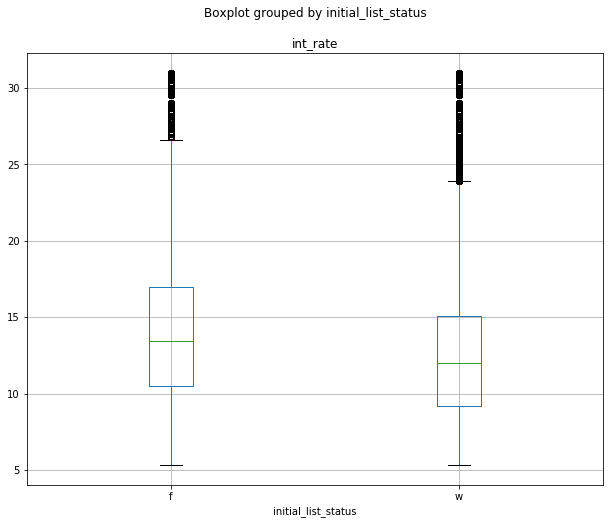

In [24]:
subcategoryANOVA(df,'initial_list_status','int_rate')

In [25]:
subcategoryttest(df,'loan_status','Fully Paid','Default','int_rate')

Ttest_indResult(statistic=-310.7971914386984, pvalue=0.0)

In [26]:
df.to_csv('lean_df_4.csv')